# Przemysław Kaleta: Spectral clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import scale

# Importing metrics:
from sklearn.metrics import fowlkes_mallows_score as fms
from sklearn.metrics import adjusted_mutual_info_score as amis
from sklearn.metrics import adjusted_rand_score as ars

# Importing clustering algorithms
from spectral import spectral_clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree
import genieclust
from sklearn.cluster import KMeans, DBSCAN, MeanShift

/home/przemyslaw/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/przemyslaw/spectral-clustering/python/spectral_aux.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [2]:
def score_tuple(Y, Y_pred):
    # average method arithmetic in amis because warnings are showed otherwise
    return fms(Y, Y_pred), amis(Y, Y_pred, average_method='arithmetic'), ars(Y, Y_pred)

def get_data(benchmark, dataset):
    label_ending = ".labels0.gz"
    matrix_ending = ".data.gz"
    matrix_path = os.path.join("..", "benchmarks", benchmark, dataset + matrix_ending)
    labels_path = os.path.join("..", "benchmarks", benchmark, dataset + label_ending)
    
    X = np.loadtxt(matrix_path, ndmin=2)
    Y = np.loadtxt(labels_path, dtype=np.int)
    
    return X, Y

def create_result_df():
    result = pd.DataFrame({"benchmark":[], 
                           "dataset":[], 
                           "algorithm": [], 
                           "n_clusters":[],
                           "FM": [], 
                           "AM": [], 
                           "AR": []
                          })
    return result 

def test_linkage(X, Y, k=2, method='single'):
    Y_pred = cut_tree(linkage(X, method=method), n_clusters=k)
    Y_pred = np.squeeze(Y_pred)
    return score_tuple(Y, Y_pred)

# My apologies for repeating some code

def test_genie(X, Y, k=2):
    g = genieclust.genie.Genie(n_clusters=2)
    Y_pred = g.fit_predict(X)
    return score_tuple(Y, Y_pred)

def test_kmeans(X, Y, k=2):
    kmeans = KMeans(n_clusters=k)
    Y_pred = kmeans.fit_predict(X)
    return score_tuple(Y, Y_pred)

def test_dbscan(X, Y, k=2, **kwargs):
    dbscan = DBSCAN(**kwargs)
    Y_pred = dbscan.fit_predict(X)
    return score_tuple(Y, Y_pred)

def test_meanshift(X, Y, k=2):
    meanshift = MeanShift()
    Y_pred = meanshift.fit_predict(X)
    return score_tuple(Y, Y_pred)

def append_result(result, benchmark, dataset, algorithm, n_clusters, fms, amis, ars):
    new_row = pd.DataFrame({"benchmark": [benchmark],
                            "dataset": [dataset],
                            "algorithm": [algorithm],
                            "n_clusters": [n_clusters],
                            "FM": [fms],
                            "AM": [amis],
                            "AR": [ars]
                           })
    result = result.append(new_row)
    return result

def plot_2d_vectors(X, Y, title=None):
    """Plots 2D vectors represented as a matrix of 2d vectors with different colors for different classes"""
    plt.scatter(X[:, 0], X[:, 1], c=Y)
    if title:
        plt.title(title)
    plt.show()

In [3]:
def report(benchmark, dataset):
    label_ending = ".labels0.gz"
    matrix_ending = ".data.gz"
    matrix_path = os.path.join("..", "benchmarks", benchmark, dataset + matrix_ending)
    labels_path = os.path.join("..", "benchmarks", benchmark, dataset + label_ending)
    result = create_result_df()
    
    X = np.loadtxt(matrix_path, ndmin=2)
    Y = np.loadtxt(labels_path, dtype=np.int)
    true_n_clusters = len(np.unique(Y))
    ks = [2, 3, 4, 5] + [true_n_clusters] # testing also on true number of clusters (it is debatable wheter it's fair)
    for k in set(ks):
        # Testing linkage methods
        methods = ['single', 'average', 'weighted', 'centroid', 'median', 'ward']
        for method in methods:
            fms, amis, ars = test_linkage(X, Y, k, method=method)
            result = append_result(result, benchmark, dataset, "_".join(["linkage", method]), k, fms, amis, ars)
            
        # Testing genie 
        fms, amis, ars = test_genie(X, Y, k)
        result = append_result(result, benchmark, dataset, "genie", k, fms, amis, ars)
        
        # Testing kmeans
        result = append_result(result, benchmark, dataset, "kmeans", k, *test_kmeans(X, Y, k))
        
        # Testing dbscan
        result = append_result(result, benchmark, dataset, "dbscan", k, *test_dbscan(X, Y))
        
        # Testing meanshift
        result = append_result(result, benchmark, dataset, "meanshift", k, *test_meanshift(X, Y))
        
    return result

## Wielki test wszystkich algorytmów
(oprócz spectral_clustering, który będzie później)

In [4]:
benchmarks = ['fcps', 'sipu', 'wut', 'other', 'graves']

result = create_result_df()
for benchmark in benchmarks:
    main_path = os.path.join("..", "benchmarks", benchmark)
    datasets = os.listdir(main_path)
    for file in datasets:
        if "txt" in file:
            file_name = file.split(".")
            dataset = file_name[0]
            print("Processing {}/{}".format(benchmark, dataset))
            result = result.append(report(benchmark, dataset))

Processing fcps/engytime
Processing fcps/twodiamonds
Processing fcps/chainlink
Processing fcps/target
Processing fcps/hepta
Processing fcps/atom
Processing fcps/lsun
Processing fcps/tetra
Processing fcps/wingnut
Processing sipu/s3
Processing sipu/flame
Processing sipu/s4
Processing sipu/s2
Processing sipu/compound
Processing sipu/jain
Processing sipu/d31
Processing sipu/a2
Processing sipu/aggregation
Processing sipu/s1
Processing sipu/unbalance
Processing sipu/pathbased
Processing sipu/a3
Processing sipu/spiral
Processing sipu/a1
Processing sipu/r15
Processing wut/smile
Processing wut/z2
Processing wut/x2
Processing wut/cross
Processing wut/x1
Processing wut/z1
Processing wut/x3
Processing wut/z3
Processing wut/twosplashes
Processing other/square
Processing other/iris
Processing other/iris5
Processing graves/fuzzyx
Processing graves/ring
Processing graves/line
Processing graves/parabolic
Processing graves/zigzag
Processing graves/dense


In [5]:
result.reset_index(drop=True)
result.to_csv("results_all_but_spectral.csv")

In [219]:
result.head()

,benchmark,dataset,algorithm,n_clusters,FM,AM,AR
0,graves,fuzzyx,linkage_single,2.0,0.448099,-0.000048,-0.000075
0,graves,fuzzyx,linkage_average,2.0,0.474544,0.180291,0.101385
0,graves,fuzzyx,linkage_weighted,2.0,0.596283,0.366460,0.346222
0,graves,fuzzyx,linkage_centroid,2.0,0.454635,0.148687,0.070490
0,graves,fuzzyx,linkage_median,2.0,0.432453,0.080034,0.019766


## Testy algorytmu spectral clustering na wybranych danych

In [38]:
benchmark, dataset = "sipu", "a1"
label_ending = ".labels0.gz"
matrix_ending = ".data.gz"
matrix_path = os.path.join("..", "benchmarks", benchmark, dataset + matrix_ending)
labels_path = os.path.join("..", "benchmarks", benchmark, dataset + label_ending)
result = create_result_df()

X = np.loadtxt(matrix_path, ndmin=2)
Y = np.loadtxt(labels_path, dtype=np.int)

In [39]:
Y_pred = spectral_clustering(X, 2, 2)

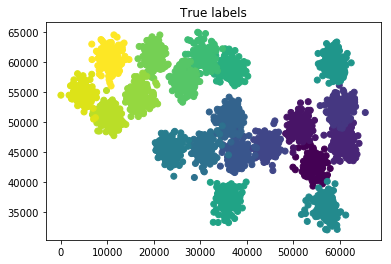

In [40]:
plot_2d_vectors(X, Y, "True labels")

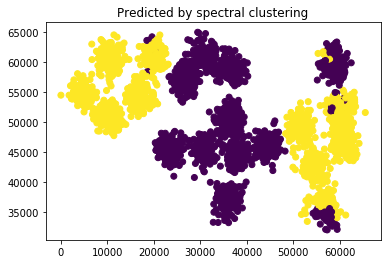

In [41]:
plot_2d_vectors(X, Y_pred, "Predicted by spectral clustering")

Małe oszustwo: sprawdźmy ile jest klas w wyjściowym zbiorze i zbadajmy skupienia naszym algorytmem dla takiego parametru k.

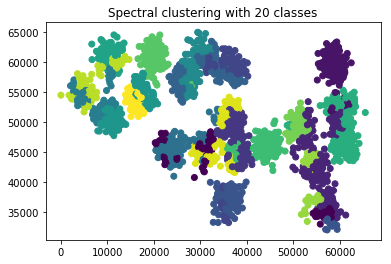

In [42]:
n_clusters = len(np.unique(Y))
Y_pred = spectral_clustering(X, n_clusters, 2)
plot_2d_vectors(X, Y_pred, "Spectral clustering with {} classes".format(n_clusters))

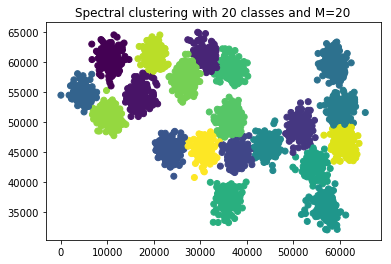

In [44]:
n_clusters = len(np.unique(Y))
Y_pred = spectral_clustering(X, n_clusters, 20)
plot_2d_vectors(X, Y_pred, "Spectral clustering with {} classes and M={}".format(n_clusters, 20))

Dla większego `M` jest lepiej.

Widzimy, że algorytm sprawuje się całkiem nieźle i dobrze wyłapuje wyraźnie widoczne skupienia punktów
w przestrzeni R^2.

Dla pewności jeszcze wyniki zwracane przez nasze miary:

In [45]:
score_tuple(Y, Y_pred)

(0.9566202869284305, 0.9674972268283543, 0.9543490150934401)

##### Jest pięknie.

## DBSCAN

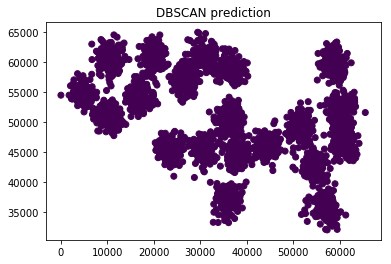

In [46]:
dbscan = DBSCAN()
Y_pred = dbscan.fit_predict(X)
plot_2d_vectors(X, Y_pred, "DBSCAN prediction")

DBSCAN za pierwszym razem nie sprawuje się najlepiej. Spróbujmy popatrzeć, co można by w nim poprawić.

Z dokumentacji podobno ma być: "Good for data which contains clusters of similar density". 

In [47]:
X_std = scale(X)

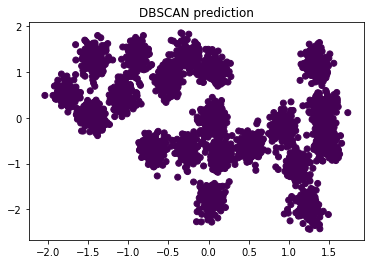

In [48]:
dbscan = DBSCAN(eps=0.48, metric="russellrao")
Y_pred = dbscan.fit_predict(X_std)
plot_2d_vectors(X_std, Y_pred, "DBSCAN prediction")

Nic nie pomaga, wygląda na to, że nie mam pojęcia jak tego algorytmu używać. Ma on niewątpliwą zaletę, że nie trzeba dopierać parametru n_clusters, ale nie na wiele się to zdaje skoro algorytm nie może tych skupień odnaleźć.

## Analiza spectral clustering na wszystkich zbiorach benchamrkowych

In [6]:
def test_spectral(X, Y, k=2, M=2):
    Y_pred = spectral_clustering(X, k, M)
    return score_tuple(Y, Y_pred)

In [7]:
def report_spectral(benchmark, dataset):
    label_ending = ".labels0.gz"
    matrix_ending = ".data.gz"
    matrix_path = os.path.join("..", "benchmarks", benchmark, dataset + matrix_ending)
    labels_path = os.path.join("..", "benchmarks", benchmark, dataset + label_ending)
    result = create_result_df()
    
    X = np.loadtxt(matrix_path, ndmin=2)
    Y = np.loadtxt(labels_path, dtype=np.int)
    true_n_clusters = len(np.unique(Y))
    ks = [2] + [true_n_clusters] # testing also on true number of clusters (it is debatable wheter it's fair)
    for k in set(ks):
        result = append_result(result, benchmark, dataset, "spectral", k, *test_spectral(X, Y, k))
        
    return result

In [8]:
benchmarks = ['fcps', 'sipu', 'wut', 'other', 'graves']

result_spectral = create_result_df()
for benchmark in benchmarks:
    
    main_path = os.path.join("..", "benchmarks", benchmark)
    datasets = os.listdir(main_path)
    for file in datasets:
        if "txt" in file:
            file_name = file.split(".")
            dataset = file_name[0]
            print("Processing {}/{}".format(benchmark, dataset))
            result_spectral = result_spectral.append(report_spectral(benchmark, dataset))
            
result_spectral.to_csv("results_spectral.csv")

Processing fcps/engytime
Processing fcps/twodiamonds
Processing fcps/chainlink
Processing fcps/target
Processing fcps/hepta
Processing fcps/atom
Processing fcps/lsun
Processing fcps/tetra
Processing fcps/wingnut
Processing sipu/s3
Processing sipu/flame
Processing sipu/s4
Processing sipu/s2
Processing sipu/compound
Processing sipu/jain
Processing sipu/d31
Processing sipu/a2
Processing sipu/aggregation
Processing sipu/s1
Processing sipu/unbalance
Processing sipu/pathbased
Processing sipu/a3
Processing sipu/spiral
Processing sipu/a1
Processing sipu/r15
Processing wut/smile
Processing wut/z2
Processing wut/x2
Processing wut/cross
Processing wut/x1
Processing wut/z1
Processing wut/x3
Processing wut/z3
Processing wut/twosplashes
Processing other/square
Processing other/iris
Processing other/iris5
Processing graves/fuzzyx
Processing graves/ring
Processing graves/line
Processing graves/parabolic
Processing graves/zigzag
Processing graves/dense


## Analiza wyników
Zobaczmy jakie metody poradziły sobie najlepiej.

In [4]:
result_no_spectral = pd.read_csv("results_all_but_spectral.csv")
result_spectral = pd.read_csv("results_spectral.csv")
result_all = pd.concat([result_no_spectral, result_spectral])
result_all = result_all[["benchmark", "dataset", "algorithm", "n_clusters", "FM", "AM", "AR"]]
result_all.head()

,benchmark,dataset,algorithm,n_clusters,FM,AM,AR
0,fcps,engytime,linkage_single,2.0,0.706675,0.000486,4.769538e-07
1,fcps,engytime,linkage_average,2.0,0.650024,0.148548,5.101383e-02
2,fcps,engytime,linkage_weighted,2.0,0.658931,0.130361,3.186027e-02
3,fcps,engytime,linkage_centroid,2.0,0.660173,0.114074,2.716402e-02
4,fcps,engytime,linkage_median,2.0,0.692347,0.038457,1.910239e-03


### Jaki algorytm radził sobie najlepiej?

In [5]:
result_all.groupby("algorithm")[["FM", "AM", "AR"]].mean().sort_values("FM", ascending=False)

,FM,AM,AR
algorithm,,,
genie,0.674968,0.613432,0.495541
linkage_single,0.645587,0.421033,0.355506
linkage_average,0.639358,0.541073,0.403116
linkage_ward,0.632729,0.563099,0.426822
kmeans,0.632069,0.560717,0.433331
linkage_centroid,0.624132,0.467082,0.348578
linkage_weighted,0.609120,0.512061,0.366689
dbscan,0.606054,0.312878,0.274218
meanshift,0.585992,0.352781,0.275816


Wygląda na to, że najlepiej radzi sobie algorytm `genie`, i to według wszystkich miar. Nasz algorytm `spectral`
osiąga nie najlepsze wyniki, ale nie są one na pewno tragiczne i nie odstają aż tak od pozostałych. Obserwowaliśmy to również na przykładowych danych - skupienia były wyraźnie odróżnione.

Rzeczą, na którą na pewno będzie trzeba zwrócić uwagę jest hiperparametr `M`. Określa on liczbę najbliższych sąsiadów, które braliśmy po uwagę. Domyślnie ustwiony był na 2, ale prawdopodobnie wyniki znacznie się polepszą po zwiększeniu tego parametru. 

In [6]:
def spectral_result(benchmark, dataset, M=2):
    X, Y = get_data(benchmark, dataset)
    true_n_clusters = len(np.unique(Y))
    
    Y_pred = spectral_clustering(X, true_n_clusters, M)
        
    return score_tuple(Y, Y_pred)

### Zależność od parametru M
#### Spirale

Weźmy przykładowy zbiór danych i dla niego przetestujmy wyniki, badając jakość wyników od parametru `M`. Należy uważać jednak, żeby parametr ten nie był zbyt duży.

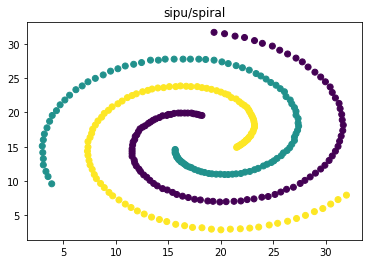

Clustering for m=2
Clustering for m=5
Clustering for m=10
Clustering for m=15
Clustering for m=20
Clustering for m=30
Clustering for m=100
Clustering for m=100000
spectral clustering: M=100000 was to large and it was changed to 311


In [25]:
benchmark, dataset = 'sipu', 'spiral'
X, Y = get_data(benchmark, dataset)
plot_2d_vectors(X, Y, title="sipu/spiral")

def test_clustering_m(benchmark, dataset):

    Ms = [2, 5, 10, 15, 20, 30, 100, 100000]

    result_m = pd.DataFrame({"m": [], "FM": [], "AM": [], "AR": []})

    for m in Ms:
        print("Clustering for m={}".format(m))
        fm, am, ar = spectral_result(benchmark, dataset, M=m)
        new_row = pd.DataFrame({"m": [m], "FM": [fm], "AM": [am], "AR": [ar]})
        result_m = result_m.append(new_row)
    return result_m.reset_index(drop=True)

result_m_spiral = test_clustering_m(benchmark, dataset)

In [26]:
result_m_spiral

,m,FM,AM,AR
0,2.0,0.468014,0.312222,0.176477
1,5.0,0.460870,0.300920,0.158499
2,10.0,0.444851,0.239378,0.085392
3,15.0,0.374703,0.073499,0.034035
4,20.0,0.344730,0.001729,0.003233
5,30.0,0.343364,0.001023,0.002459
6,100.0,0.332632,-0.002932,-0.003074
7,100000.0,0.571804,-0.000179,-0.000201


Obserwujemy bardzo dziwną zależność. Im większe `M` tym gorsze wyniki. Sprawdźmy jak to wygląda na obrazku.

In [10]:
true_n_clusters = len(np.unique(Y))
Y_pred_2 = spectral_clustering(X, true_n_clusters, 2)
Y_pred_30 = spectral_clustering(X, true_n_clusters, 30)

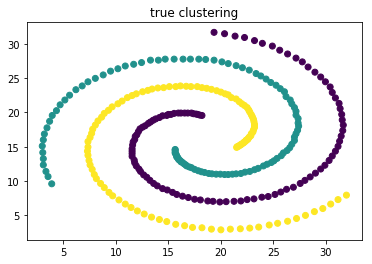

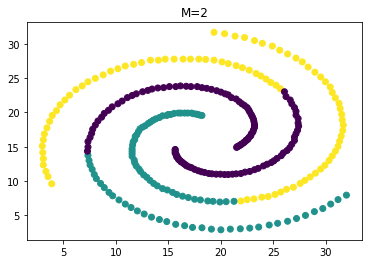

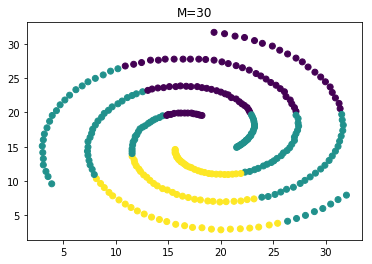

In [12]:
plot_2d_vectors(X, Y, "true clustering")
plot_2d_vectors(X, Y_pred_2, "M=2")
plot_2d_vectors(X, Y_pred_30, "M=30")

Wygląda na to, że po prostu zbiór na którym testujemy jest zdecydowanie **za trudny** dla naszego algorytmu, który najwyraźniej zbyt dużą uwagę przywiązuje do odległości w przestrzeni niż do oddzielania ciągłych lini widocznych na spiralach powyżej.

#### fuzzyx

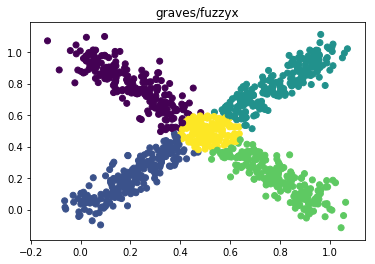

In [29]:
benchmark, dataset = 'graves', 'fuzzyx'
X, Y = get_data(benchmark, dataset)
plot_2d_vectors(X, Y, title="graves/fuzzyx")

In [30]:
result_m_fuzzyx = test_clustering_m(benchmark, dataset)

Clustering for m=2
Clustering for m=5
Clustering for m=10
Clustering for m=15
Clustering for m=20
Clustering for m=30
Clustering for m=100
Clustering for m=100000
spectral clustering: M=100000 was to large and it was changed to 999


In [31]:
result_m_fuzzyx

,m,FM,AM,AR
0,2.0,0.525374,0.525329,0.388910
1,5.0,0.541878,0.600122,0.403806
2,10.0,0.592665,0.629559,0.486719
3,15.0,0.580144,0.623032,0.468937
4,20.0,0.588864,0.630440,0.479394
5,30.0,0.557420,0.590718,0.440402
6,100.0,0.599069,0.637676,0.491358
7,100000.0,0.486507,0.333867,0.167090


Pocieszająca wiadomość: Ten zbiór nie był takim wyzwaniem dla naszego algorytmu. Zdecydowanie lepiej sobie radził sobie wraz ze wzrostem `M` i najlepsze wyniki osiągał dla `M` równego mniej więcej 20.

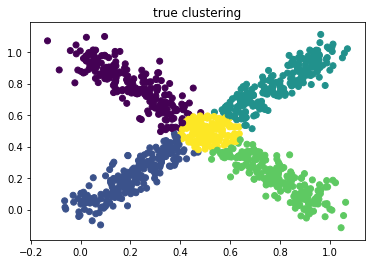

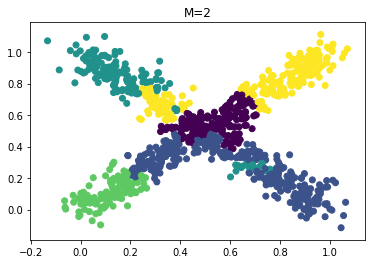

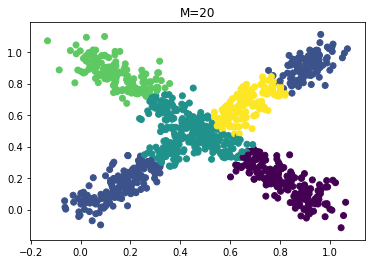

In [32]:
true_n_clusters = len(np.unique(Y))
Y_pred_2 = spectral_clustering(X, true_n_clusters, 2)
Y_pred_20 = spectral_clustering(X, true_n_clusters, 20)

plot_2d_vectors(X, Y, "true clustering")
plot_2d_vectors(X, Y_pred_2, "M=2")
plot_2d_vectors(X, Y_pred_20, "M=20")

Widzimy jednak, że wyniki wciąż nie są idealne.

### Jakie zbiory sprawiały najwięcej problemu algorytmom?

In [36]:
result_all.groupby(["benchmark", "dataset"])["FM", "AM", "AR"].mean().sort_values("FM")

FM        AM        AR
benchmark dataset                                  
sipu      a3           0.296289  0.388097  0.160768
          s4           0.326808  0.257333  0.119089
          a2           0.335363  0.425418  0.182382
          s3           0.358200  0.340376  0.157069
          d31          0.372769  0.482146  0.226487
          s2           0.398705  0.391202  0.198324
          a1           0.408608  0.472928  0.233032
          s1           0.432403  0.427135  0.238069
          r15          0.457062  0.515749  0.270527
wut       cross        0.492281  0.165566  0.061827
sipu      spiral       0.494656  0.191610  0.149410
wut       z1           0.515870  0.195448  0.144312
graves    fuzzyx       0.554112  0.389447  0.270259
wut       x2           0.569401  0.325493  0.196293
fcps      hepta        0.585631  0.577792  0.383509
sipu      pathbased    0.607445  0.350525  0.285710
graves    zigzag       0.616088  0.502299  0.324817
wut       twosplashes  0.642008  0.176937  0.198363
          x3           0.650235  0.509206  0.389059
other     iris5        0.676419  0.402534  0.304671
graves    line         0.680604  0.483968  0.327897
other     square       0.693369  0.362051  0.315978
sipu      jain         0.694236  0.422991  0.327474
wut       z2           0.695432  0.549926  0.442990
fcps      tetra        0.697223  0.495108  0.430585
sipu      unbalance    0.709095  0.565498  0.427035
          aggregation  0.716620  0.644679  0.535676
fcps      engytime     0.717410  0.309354  0.316887
sipu      compound     0.721569  0.645493  0.543908
fcps      chainlink    0.730158  0.483866  0.425161
graves    parabolic    0.740194  0.449984  0.487931
fcps      atom         0.744919  0.416124  0.376414
sipu      flame        0.747737  0.415980  0.366943
fcps      lsun         0.748698  0.655838  0.549543
other     iris         0.750929  0.681060  0.575030
graves    ring         0.769213  0.560682  0.514317
fcps      target       0.771562  0.455960  0.397690
wut       smile        0.781563  0.717936  0.646874
fcps      wingnut      0.796391  0.590785  0.585270
wut       z3           0.807941  0.708017  0.658205
graves    dense        0.842743  0.635756  0.653805
fcps      twodiamonds  0.845285  0.679419  0.644568
wut       x1           0.855085  0.823816  0.751965

Wygląda na to, ze twórcy benchmarków `sipu` byli szczególni złośliwi. Ich zbiory są trudne do dobrej analizy skupień. 

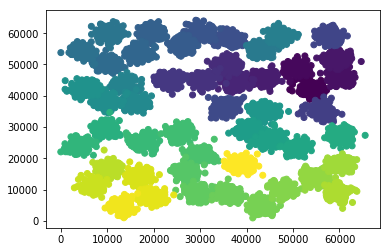

In [51]:
X, Y = get_data('sipu', 'a3')
plot_2d_vectors(X, Y)

Z drugiej strony może to wynikać z tego, że moją analizę robiłem dla różnych k (typowo dość małych) i dla wszystkich liczyłem wyniki. Ten zbiór ma bardzo dużo skupień, więc nic dziwnego, że wyniki są gorsze dla algorytmów którym mówimy, że `n_clusters=2`.

### Wpływ skalowania na wyniki algorytmu.

In [61]:
def test_scaling(benchmark, dataset):
    print("Results on: {}/{}".format(benchmark, dataset))
    X, Y = get_data(benchmark, dataset)
    
    n_clusters = len(np.unique(Y))
    M = 20
    
    # Without scaling
    Y_pred = spectral_clustering(X, n_clusters, M)
    print("Scores without scaling", score_tuple(Y, Y_pred))
    
    # With scaling
    X = scale(X)
    Y_pred_sc = spectral_clustering(X, n_clusters, M)
    print("Scores after scaling", score_tuple(Y, Y_pred_sc))
    print()

In [62]:
test_scaling('fcps', 'hepta')
test_scaling('sipu', 'jain')
test_scaling('wut', 'smile')
test_scaling('graves', 'line')

Results on: fcps/hepta
Scores without scaling (0.8736731202621171, 0.9298476576054564, 0.8488991318030196)
Scores after scaling (0.873496524179254, 0.9291206546097582, 0.8502498354835254)

Results on: sipu/jain
Scores without scaling (0.6359354855474821, 0.30707621722511874, 0.1783579197237376)
Scores after scaling (0.6359354855474821, 0.30707621722511874, 0.1783579197237376)

Results on: wut/smile
Scores without scaling (0.46834455125458807, 0.6371830722973304, 0.2910624321594228)
Scores after scaling (0.44899234492693, 0.6164595442702665, 0.25686757055988085)

Results on: graves/line
Scores without scaling (0.5974023177882316, 0.17775036657338647, -0.01300777369332629)
Scores after scaling (0.5985172087165582, 0.18468415481658454, -0.001486128414142843)



Skalowanie niewiele wpływa na wyniki na tych danych.

## Wnioski

W analizie skupień dużym problemem jest brak wiedzy a priori ile skupień mamy w zbiorze, dlatego trudno czasem ocenić wyniki. Niektóre algorymy same próbują sobie estymować liczbę skupień, ale trudno (mi) się z nimi pracuje, mają jakieś tajemnicze hiperparametry (dbscan), które trudno dobrać odpowiednio. Dodatkowo kwestia, że jakiś punkt przynależy do określonego skupienia może być subiektywna i nie ma prawdziwych odpowiedzi tak jak w uczeniu nadzorowanym.

Przetestowaliśmy wyniki wielu algorytmów analizy skupień na wielu zbiorach. Średnio najlepszy okazał się `genie`.

Zbadaliśmy zależność wyników algorytmu od parametru `M`. Wygląda na to, że spectral clustering ma problemy z odnajdywaniem skupień dla zbyt małego `M`, na przykład równego 2. Zauważalnie lepiej radzi sobie natomiast dla `M=20`. 

Na otrzymanych danych nie wykryliśmy wpływu skalowania. Może to być spowodowane faktem, że w algorytmie pod uwagę bierzemy tylko indeksy najbliższych sąsiadów, zatem to jakie konkretnie będą te odległości nie wpłynie na wyniki.

W projekcie tym wykorzystałem Cythona do dwóch pomocniczych funkcji. Jak się okazuje przepisanie funkcji z kodu Pythonowego do Cythona jest wyjątkowo proste (na pewno prostsze niż w Rcpp) i niewiele trzeba zmieniać, a potrafi to przyśpieszyć działanie programu.